In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
print(jax.devices())

jax.config.update("jax_enable_x64", True)

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.stats import get_pow_spec_1D, get_pow_spec_quadrupole
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

[cuda(id=0)]


In [2]:
N, Z_I, Z_F = 256, 99, 0
R = 3.906
L = R * N
lpt_method = "ALPT"

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    rsd=False, 
    lpt_method=lpt_method,
    cweb = 'PhiWeb'
)
fmodel = FModel(fm_cfg)

N_TR is not set. No bias in forward model.


In [3]:
q = fmodel.input_arr(jax.random.PRNGKey(1))
delta_lpt = fmodel.delta_lpt(q)
cweb = fmodel.cweb(delta_lpt)

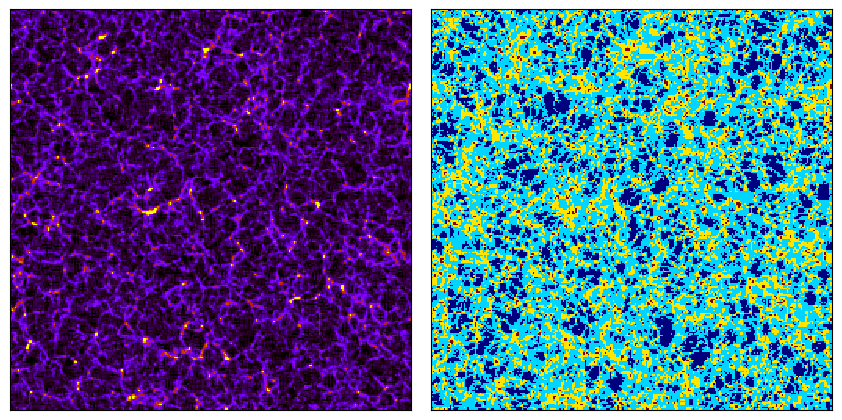

In [4]:
fig, ax = plot_cubes(
    [delta_lpt, cweb],
    cmap=["gnuplot", 'jet'],
    vlim=[(-1, 10),(0,3)],
    width=1, axis=2, idx=N//2,
    figsize=7.5
)

In [5]:
N3 = N**3
rho_lpt = 1+delta_lpt

rho_V = rho_lpt[cweb==0]
rho_S = rho_lpt[cweb==1]
rho_F = rho_lpt[cweb==2]
rho_K = rho_lpt[cweb==3]

cells_V = jnp.sum(cweb==0)
cells_S = jnp.sum(cweb==1)
cells_F = jnp.sum(cweb==2)
cells_K = jnp.sum(cweb==3)

mean_rho_V = jnp.sum(rho_V) / cells_V
mean_rho_S = jnp.sum(rho_S) / cells_S
mean_rho_F = jnp.sum(rho_F) / cells_F
mean_rho_K = jnp.sum(rho_K) / cells_K

print(f"Total: {rho_lpt.min():0.2f}, {rho_lpt.max():0.2f}")
print(f"V: {100*cells_V/N3:0.2f}, {mean_rho_V:0.04f}, ({rho_V.min():0.2f}, {rho_V.max():0.2f})")
print(f"S: {100*cells_S/N3:0.2f}, {mean_rho_S:0.04f}, ({rho_S.min():0.2f}, {rho_S.max():0.2f})")
print(f"F: {100*cells_F/N3:0.2f}, {mean_rho_F:0.04f}, ({rho_F.min():0.2f}, {rho_F.max():0.2f})")
print(f"K: {100*cells_K/N3:0.2f}, {mean_rho_K:0.04f}, ({rho_K.min():0.2f}, {rho_K.max():0.2f})")

Total: 0.00, 67.13
V: 20.01, 0.2242, (0.00, 1.05)
S: 54.91, 0.6433, (0.00, 9.25)
F: 23.15, 2.0923, (0.00, 28.82)
K: 1.93, 6.1049, (1.30, 67.13)


In [6]:
bins = jnp.linspace(0, 20, 200)

bins = jnp.logspace(-4, 2, 200)

dist, bin_edges = jnp.histogram(rho_lpt, bins)
dist_V, bin_edges = jnp.histogram(rho_V, bins)
dist_S, bin_edges = jnp.histogram(rho_S, bins)
dist_F, bin_edges = jnp.histogram(rho_F, bins)
dist_K, bin_edges = jnp.histogram(rho_K, bins)

bin_difs = bins[1:]-bins[:-1]
bin_centers = bin_difs*0.5

dists = [dist_V, dist_S, dist_F, dist_K, dist]

Text(0, 0.5, 'y')

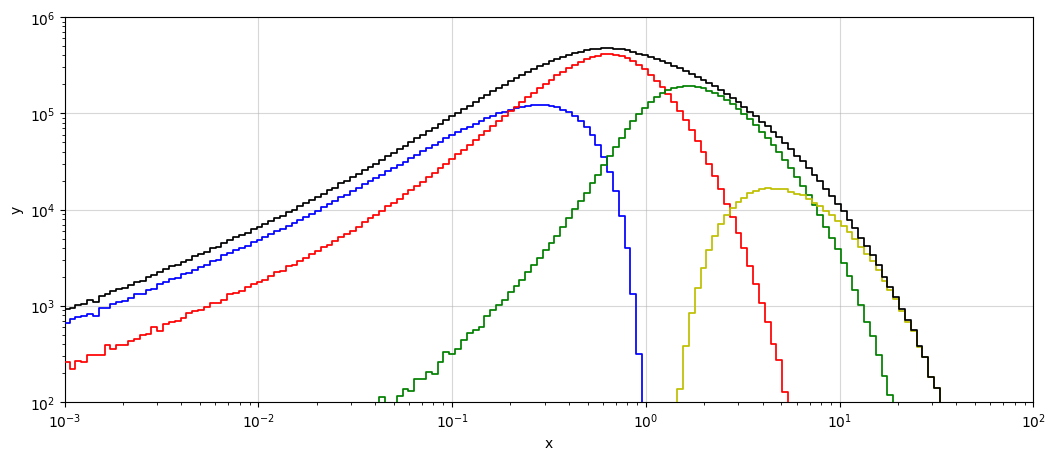

In [8]:
fs, rat = 5, 2.5
fig, ax = plt.subplots(1, 1, figsize=(fs * rat, fs))

lw = 0.25*fs
alpha = 1
cs = ["b", "r", "g", "y", 'k']

for i in range(5):
    ax.step(
        bins[:-1] + bin_difs / 2,
        dists[i],
        where='mid',
        color=cs[i],
        alpha=alpha,
        zorder=10,
        linewidth=lw,
    )


ax.grid(True, alpha=0.5)

ax.set_xlim(1e-3, 1e2)
ax.set_ylim(1e2, 1e6)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("x")
ax.set_ylabel("y")

In [9]:
eps = 1e-7
rho_thr_V, e_thr_V = 0.1, 2.7
rho_thr_S, e_thr_S = 0.2, 2.8
rho_thr_F, e_thr_F = 0.4, 1.5
rho_thr_K, e_thr_K = 0.5, 1.4

hp_V = jnp.exp(-jnp.power(((rho_V + eps) / rho_thr_V + eps), -e_thr_V))
hp_S = jnp.exp(-jnp.power(((rho_S + eps) / rho_thr_S + eps), -e_thr_S))
hp_F = jnp.exp(-jnp.power(((rho_F + eps) / rho_thr_F + eps), -e_thr_F))
hp_K = jnp.exp(-jnp.power(((rho_K + eps) / rho_thr_K + eps), -e_thr_K))

rho2_V = rho_V * hp_V
rho2_S = rho_S * hp_S
rho2_F = rho_F * hp_F
rho2_K = rho_K * hp_K

bins = jnp.logspace(-5, 2, 200)

dist2_V, bin_edges = jnp.histogram(rho2_V, bins)
dist2_S, bin_edges = jnp.histogram(rho2_S, bins)
dist2_F, bin_edges = jnp.histogram(rho2_F, bins)
dist2_K, bin_edges = jnp.histogram(rho2_K, bins)

bin_difs = bins[1:]-bins[:-1]
bin_centers = bin_difs*0.5

dists2 = [dist2_V, dist2_S, dist2_F, dist2_K]

In [25]:
eps = 1e-7
alpha_V = 1.05
alpha_S = 1.11
alpha_F = 1.23
alpha_K = 1.3

rho2_V = jnp.power(rho_V + eps, alpha_V)
rho2_S = jnp.power(rho_F + eps, alpha_F)
rho2_F = jnp.power(rho_S + eps, alpha_S)
rho2_K = jnp.power(rho_K + eps, alpha_K)

bins = jnp.logspace(-5, 2, 200)

dist2_V, bin_edges = jnp.histogram(rho2_V, bins)
dist2_S, bin_edges = jnp.histogram(rho2_S, bins)
dist2_F, bin_edges = jnp.histogram(rho2_F, bins)
dist2_K, bin_edges = jnp.histogram(rho2_K, bins)

bin_difs = bins[1:]-bins[:-1]
bin_centers = bin_difs*0.5

dists2 = [dist2_V, dist2_S, dist2_F, dist2_K]

Text(0, 0.5, 'y')

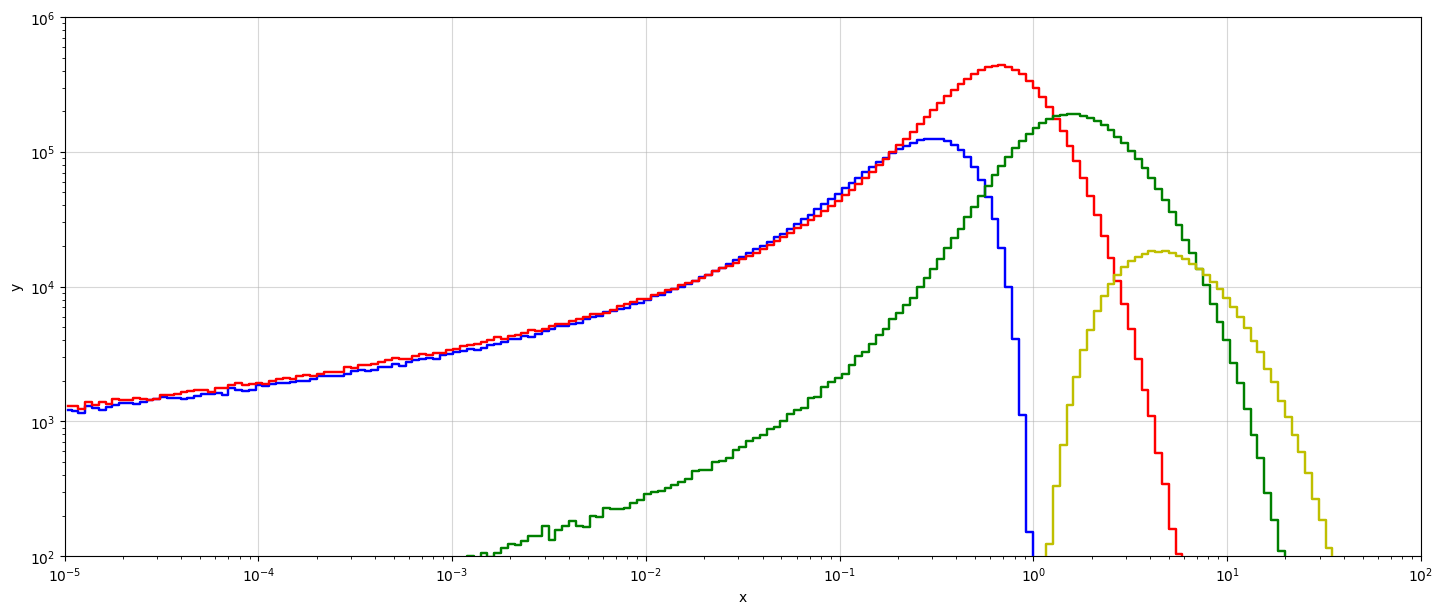

In [10]:
fs, rat = 7, 2.5
fig, ax = plt.subplots(1, 1, figsize=(fs * rat, fs))

lw = 0.25*fs
alpha = 1
cs = ["b", "r", "g", "y", 'k']

for i in range(4):
    ax.step(
        bins[:-1] + bin_difs / 2,
        dists2[i],
        where='mid',
        color=cs[i],
        alpha=alpha,
        zorder=10,
        linewidth=lw,
    )

ax.grid(True, alpha=0.5)

ax.set_xlim(1e-5, 1e2)
ax.set_ylim(1e2, 1e6)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("x")
ax.set_ylabel("y")